## Check Subgrid Noising
Check the data-space impact of devoxelization of CHARM halos/galaxies.

In [10]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
from os.path import join
import pickle
import json
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('./style.mcstyle')   # noqa
import numpy as np
import torch
import seaborn as sns
import pandas as pd
import warnings
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Test on Quijote vs CHARM

In [ ]:
from cmass.infer.loaders import get_cosmo
from cmass.utils import cosmo_to_astropy

wdir = '/anvil/scratch/x-mho1/cmass-ili'

# LOAD QUIJOTE
nbody = 'quijote'
sim = 'nbody'
L, N = 1000, 128
lhid = 663
simdir = join(wdir, nbody, sim, f'L{L}-N{N}', f'{lhid}')
filename = join(simdir, 'halos.h5')  # 'galaxies', 'hod06630.h5')
print(filename)
filename = join(simdir, 'galaxies', 'hod06630.h5')
z = 0.5
a = f'{1/(1+z):.6f}'
with h5py.File(filename, 'r') as f:
    qpos = f[a]['pos'][...]
    qvel = f[a]['vel'][...]
    qmass = f[a]['mass'][...]

cosmo = get_cosmo(simdir)
cosmo = cosmo_to_astropy(cosmo)

# LOAD CHARM
nbody = 'quijotelike'
sim = 'fastpm'
L, N = 1000, 128
lhid = 663
simdir = join(wdir, nbody, sim, f'L{L}-N{N}', f'{lhid}')
filename = join(simdir, 'halos.h5')  # 'galaxies', 'hod06630.h5')
print(filename)
filename = join(simdir, 'galaxies', 'hod06630.h5')
with h5py.File(filename, 'r') as f:
    cpos = f[a]['pos'][...]
    cvel = f[a]['vel'][...]
    cmass = f[a]['mass'][...]
    # flag = f[a]['gal_type'][...]
# cpos = (qpos // (L/N) * (L/N)) + (L/N) / 2
# cvel = qvel
# cmass = qmass

/anvil/scratch/x-mho1/cmass-ili/quijote/nbody/L1000-N128/663/halos.h5
/anvil/scratch/x-mho1/cmass-ili/quijotelike/fastpm/L1000-N128/663/halos.h5


[12:24:03-INFO] Running calcBk_bfast...
[12:24:06-INFO] Finished calcBk_bfast... (0m3s)
[12:24:08-INFO] Running calcBk_bfast...
[12:24:11-INFO] Finished calcBk_bfast... (0m3s)
[12:24:12-INFO] Running calcBk_bfast...
[12:24:15-INFO] Finished calcBk_bfast... (0m3s)
[12:24:17-INFO] Running calcBk_bfast...
[12:24:19-INFO] Finished calcBk_bfast... (0m2s)
[12:24:21-INFO] Running calcBk_bfast...
[12:24:24-INFO] Finished calcBk_bfast... (0m2s)
[12:24:25-INFO] Running calcBk_bfast...
[12:24:29-INFO] Finished calcBk_bfast... (0m3s)
[12:24:30-INFO] Running calcBk_bfast...
[12:24:32-INFO] Finished calcBk_bfast... (0m1s)
[12:24:33-INFO] Running calcBk_bfast...
[12:24:35-INFO] Finished calcBk_bfast... (0m1s)
[12:24:36-INFO] Running calcBk_bfast...
[12:24:39-INFO] Finished calcBk_bfast... (0m3s)
[12:24:41-INFO] Running calcBk_bfast...
[12:24:45-INFO] Finished calcBk_bfast... (0m4s)
[12:24:46-INFO] Running calcBk_bfast...
[12:24:50-INFO] Finished calcBk_bfast... (0m3s)
[12:24:51-INFO] Running calcBk_b

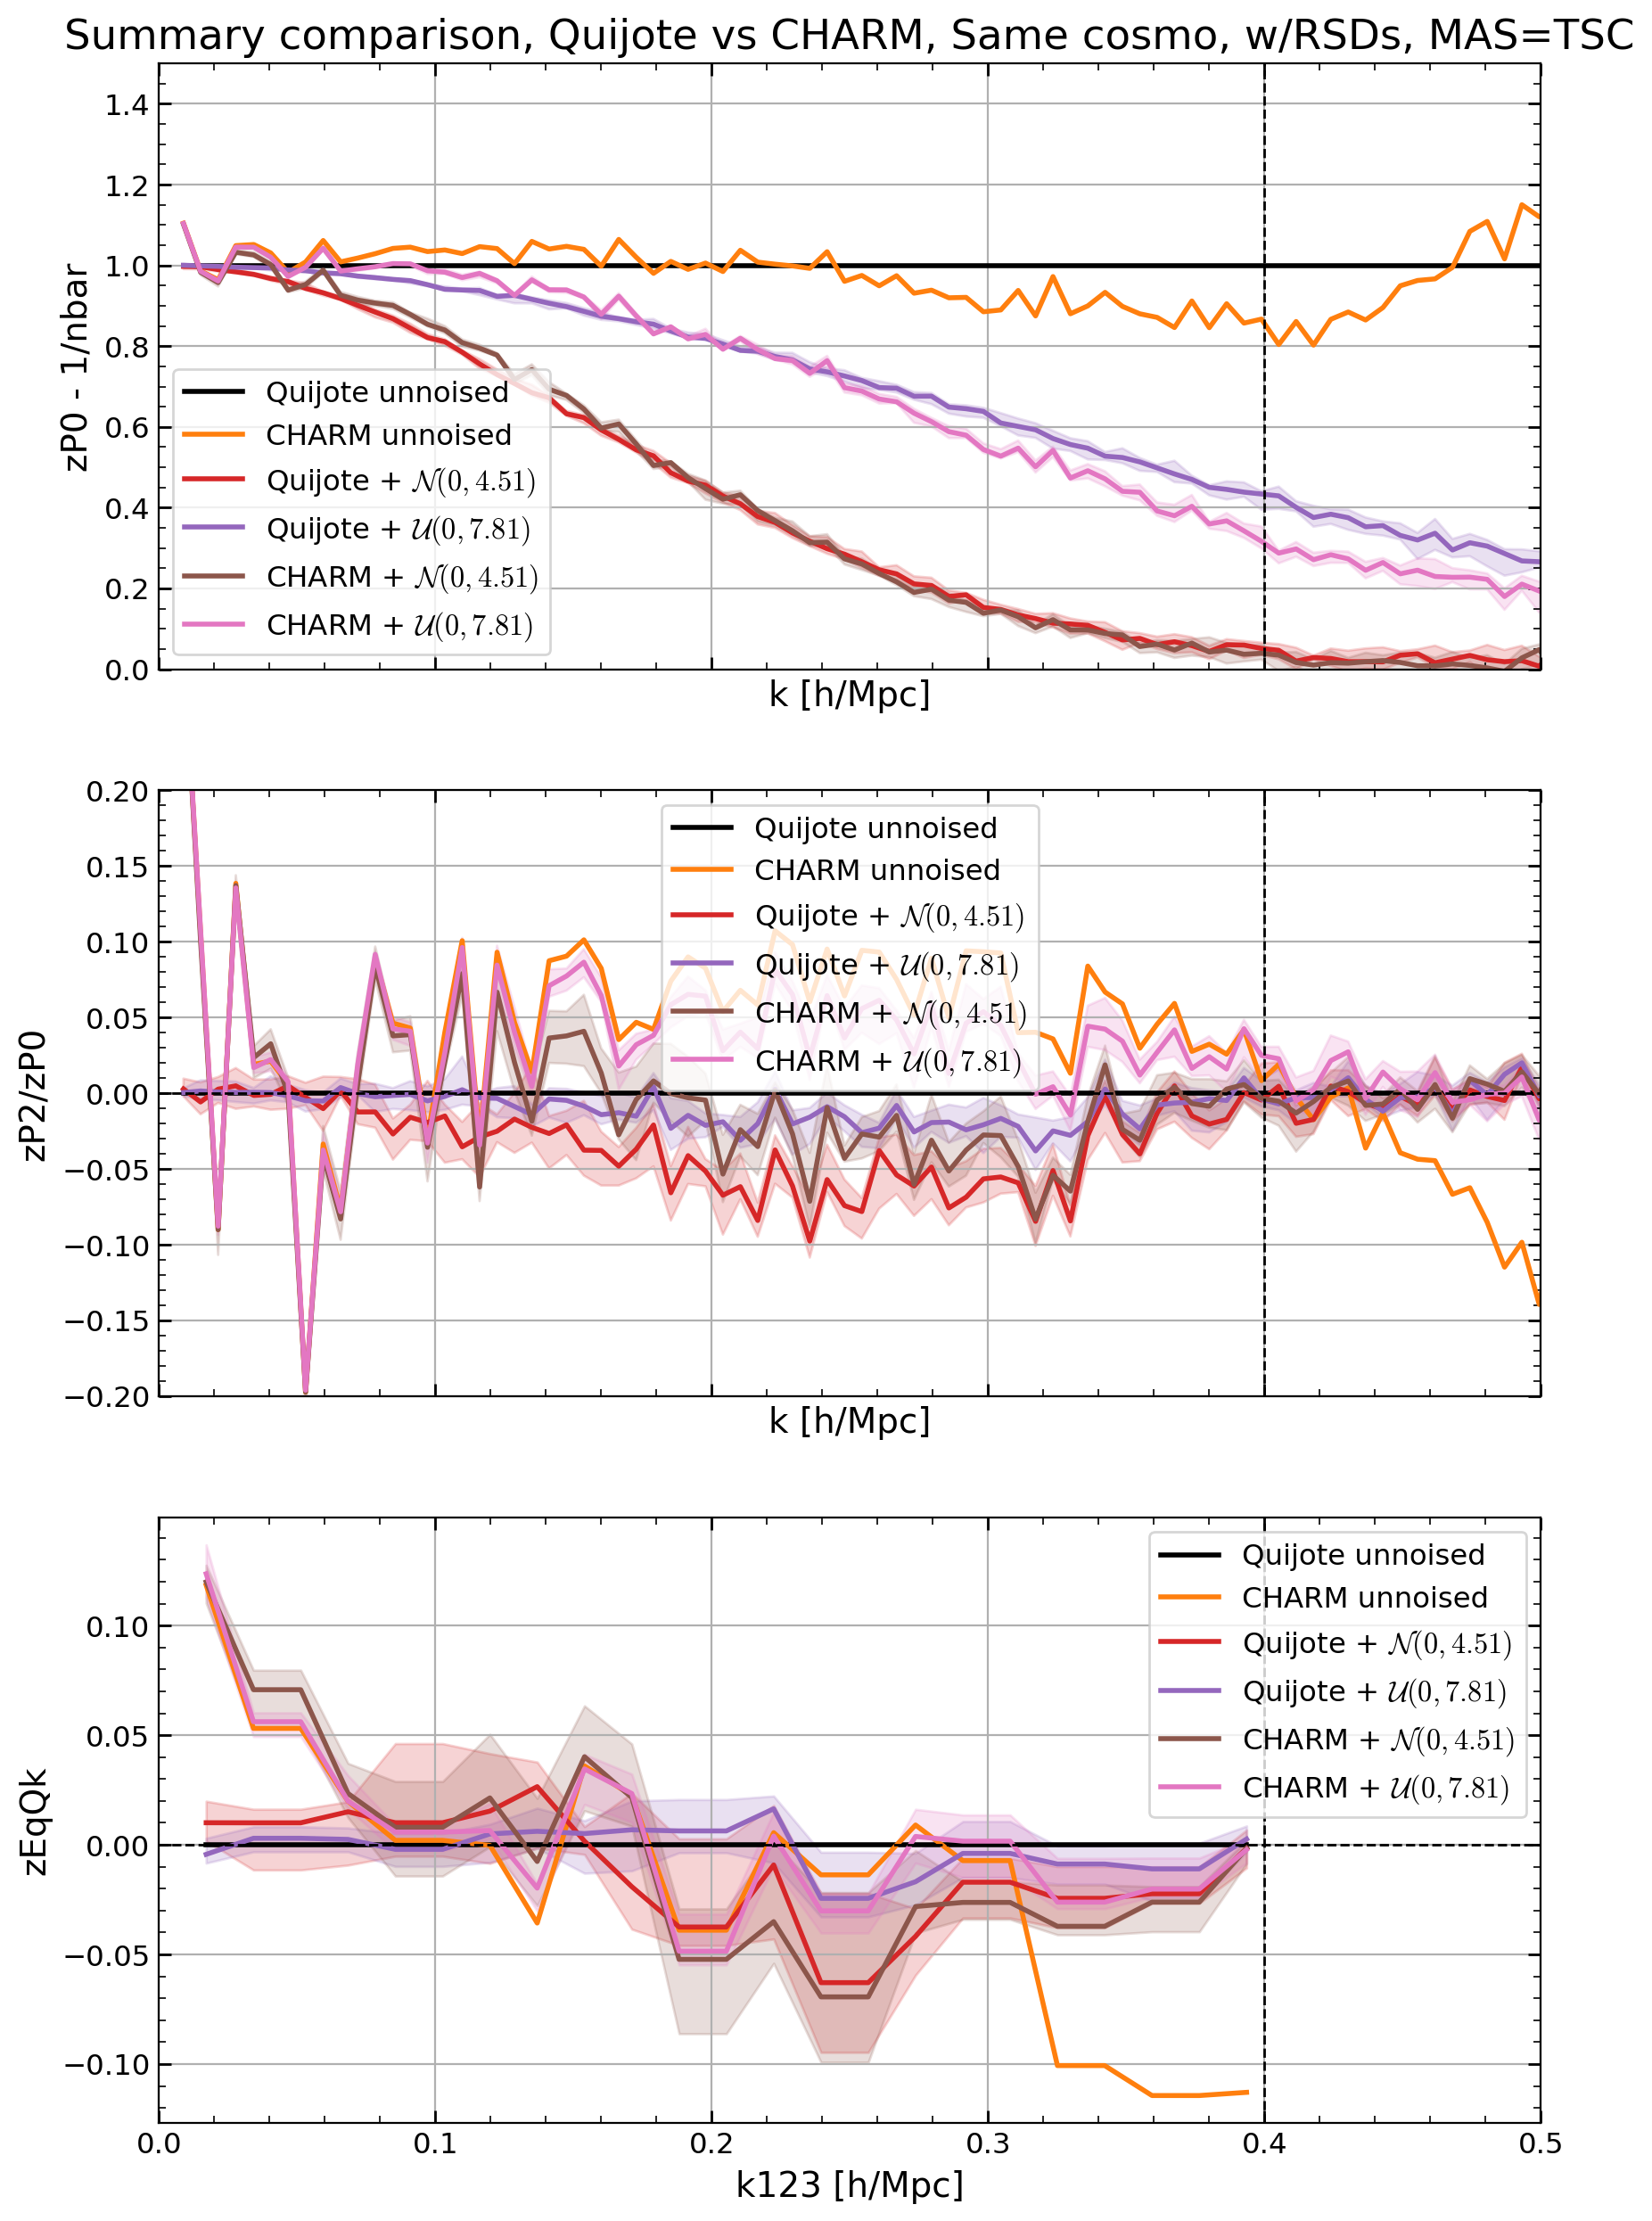

In [29]:
from cmass.diagnostics.summ import run_pylians
from cmass.diagnostics.tools import MA, MAz
from copy import deepcopy

Nrepeat = 10
Ngrid = N*2
MAS = 'TSC'
nbar = 1e-4
Nmax = int(nbar * L**3)

mask = np.argsort(qmass)[-Nmax:]
# mask = np.ones(len(qpos), dtype=bool)  # Use all particles
pos = qpos[mask]
vel = qvel[mask]
_nbar = len(pos) / L**3

mask = np.argsort(cmass)[-Nmax:]
# mask = np.ones(len(cpos), dtype=bool)  # Use all particles
chpos = cpos[mask]
chvel = cvel[mask]
_cnbar = len(chpos) / L**3


def compute_pk(pos, vel, L, Ngrid, cosmo, z, MAS='TSC', axis=0):
    """Compute the power spectrum."""
    pos = deepcopy(pos)
    vel = deepcopy(vel)
    rho_z = MAz(pos, vel, L, Ngrid, cosmo, z, MAS=MAS, axis=axis)
    out = run_pylians(rho_z, ['Pk'], L, axis=axis, num_threads=0,
                      use_rsd=True, MAS=MAS)
    rho_z = MAz(pos, vel, L, Ngrid//2, cosmo, z, MAS=MAS, axis=axis)
    out2 = run_pylians(rho_z, ['Bk'], L, axis=axis, num_threads=0,
                       use_rsd=True, MAS=MAS)
    mask = ((out2['zBk_k123'][0] == out2['zBk_k123'][1]) &
            (out2['zBk_k123'][0] == out2['zBk_k123'][2]))
    out2['zEqQk_k123'] = out2['zBk_k123'][0, mask]
    out2['zEqQk'] = out2['zQk'][0, mask]
    # Combine out and out2 into a single dictionary
    result = dict(out)
    result.update(out2)
    return result


f, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# plot unnoised Quijote
out = compute_pk(pos, vel, L, Ngrid, cosmo, z, MAS=MAS)
base = [out['zPk'][:, 0] - 1 / _nbar,
        out['zPk'][:, 1] / out['zPk'][:, 0],
        out['zEqQk']]
axs[0].plot(out['zPk_k3D'], (out['zPk'][:, 0] - 1 / _nbar) /
            base[0], c='k', label='Quijote unnoised')
axs[1].plot(out['zPk_k3D'], (out['zPk'][:, 1] / out['zPk'][:, 0]) -
            base[1], c='k', label='Quijote unnoised')
axs[2].plot(out['zEqQk_k123'], (out['zEqQk']) -
            base[2], c='k', label='Quijote unnoised')

# plot unnoised CHARM
out = compute_pk(chpos, chvel, L, Ngrid, cosmo, z, MAS=MAS)
axs[0].plot(out['zPk_k3D'], (out['zPk'][:, 0] - 1 / _cnbar) /
            base[0], c='C1', label='CHARM unnoised')
axs[1].plot(out['zPk_k3D'], (out['zPk'][:, 1] / out['zPk'][:, 0]) -
            base[1], c='C1', label='CHARM unnoised')
axs[2].plot(out['zEqQk_k123'], (out['zEqQk']) -
            base[2], c='C1', label='CHARM unnoised')

# plot noised Gaussian Quijote
Lnoise = (1000/128)/np.sqrt(3)  # Set by CHARM resolution
_Pk0s, _Pk2s, _Bks = [], [], []
for _ in range(Nrepeat):
    _pos = pos + Lnoise * np.random.randn(*pos.shape).astype(np.float32)
    _vel = vel
    out = compute_pk(_pos, _vel, L, Ngrid, cosmo, z, MAS=MAS)
    k = out['zPk_k3D']
    k123 = out['zEqQk_k123']
    _Pk0s.append(out['zPk'][:, 0] - 1/_nbar)
    _Pk2s.append(out['zPk'][:, 1]/out['zPk'][:, 0])
    _Bks.append(out['zEqQk'])
percs = np.percentile(_Pk0s, [50, 16, 84], axis=0)
axs[0].plot(out['zPk_k3D'], percs[0]/base[0], c='C3',
            label=r'Quijote + $\mathcal{N}(0, ' + f'{Lnoise:.2f})$')
axs[0].fill_between(out['zPk_k3D'], percs[1]/base[0],
                    percs[2]/base[0], alpha=0.2, color='C3')
percs = np.percentile(_Pk2s, [50, 16, 84], axis=0)
axs[1].plot(out['zPk_k3D'], percs[0]-base[1], c='C3',
            label=r'Quijote + $\mathcal{N}(0, ' + f'{Lnoise:.2f})$')
axs[1].fill_between(out['zPk_k3D'], percs[1]-base[1],
                    percs[2]-base[1], alpha=0.2, color='C3')
percs = np.percentile(_Bks, [50, 16, 84], axis=0)
axs[2].plot(k123, percs[0]-base[2], c='C3',
            label=r'Quijote + $\mathcal{N}(0, ' + f'{Lnoise:.2f})$')
axs[2].fill_between(k123, percs[1]-base[2], percs[2] -
                    base[2], alpha=0.2, color='C3')

# plot noised Uniform Quijote
Lnoise = (1000/128)  # Set by CHARM resolution
_Pk0s, _Pk2s, _Bks = [], [], []
for _ in range(Nrepeat):
    _pos = pos + Lnoise * \
        np.random.rand(*pos.shape).astype(np.float32) - Lnoise/2
    _vel = vel
    out = compute_pk(_pos, _vel, L, Ngrid, cosmo, z, MAS=MAS)
    k = out['zPk_k3D']
    k123 = out['zEqQk_k123']
    _Pk0s.append(out['zPk'][:, 0] - 1/_nbar)
    _Pk2s.append(out['zPk'][:, 1]/out['zPk'][:, 0])
    _Bks.append(out['zEqQk'])
percs = np.percentile(_Pk0s, [50, 16, 84], axis=0)
axs[0].plot(out['zPk_k3D'], percs[0]/base[0], c='C4',
            label=r'Quijote + $\mathcal{U}(0, ' + f'{Lnoise:.2f})$')
axs[0].fill_between(out['zPk_k3D'], percs[1]/base[0],
                    percs[2]/base[0], alpha=0.2, color='C4')
percs = np.percentile(_Pk2s, [50, 16, 84], axis=0)
axs[1].plot(out['zPk_k3D'], percs[0]-base[1], c='C4',
            label=r'Quijote + $\mathcal{U}(0, ' + f'{Lnoise:.2f})$')
axs[1].fill_between(out['zPk_k3D'], percs[1]-base[1],
                    percs[2]-base[1], alpha=0.2, color='C4')
percs = np.percentile(_Bks, [50, 16, 84], axis=0)
axs[2].plot(k123, percs[0]-base[2], c='C4',
            label=r'Quijote + $\mathcal{U}(0, ' + f'{Lnoise:.2f})$')
axs[2].fill_between(k123, percs[1]-base[2], percs[2] -
                    base[2], alpha=0.2, color='C4')

# plot noised Gaussian CHARM
Lnoise = (1000/128)/np.sqrt(3)  # Set by CHARM resolution
_Pk0s, _Pk2s, _Bks = [], [], []
for _ in range(Nrepeat):
    _pos = chpos + Lnoise * np.random.randn(*chpos.shape).astype(np.float32)
    _vel = chvel
    out = compute_pk(_pos, _vel, L, Ngrid, cosmo, z, MAS=MAS)
    k = out['zPk_k3D']
    k123 = out['zEqQk_k123']
    _Pk0s.append(out['zPk'][:, 0] - 1/_cnbar)
    _Pk2s.append(out['zPk'][:, 1]/out['zPk'][:, 0])
    _Bks.append(out['zEqQk'])
percs = np.percentile(_Pk0s, [50, 16, 84], axis=0)
axs[0].plot(out['zPk_k3D'], percs[0]/base[0], c='C5',
            label=r'CHARM + $\mathcal{N}(0, ' + f'{Lnoise:.2f})$')
axs[0].fill_between(out['zPk_k3D'], percs[1]/base[0],
                    percs[2]/base[0], alpha=0.2, color='C5')
percs = np.percentile(_Pk2s, [50, 16, 84], axis=0)
axs[1].plot(out['zPk_k3D'], percs[0]-base[1], c='C5',
            label=r'CHARM + $\mathcal{N}(0, ' + f'{Lnoise:.2f})$')
axs[1].fill_between(out['zPk_k3D'], percs[1]-base[1],
                    percs[2]-base[1], alpha=0.2, color='C5')
percs = np.percentile(_Bks, [50, 16, 84], axis=0)
axs[2].plot(k123, percs[0]-base[2], c='C5',
            label=r'CHARM + $\mathcal{N}(0, ' + f'{Lnoise:.2f})$')
axs[2].fill_between(k123, percs[1]-base[2], percs[2] -
                    base[2], alpha=0.2, color='C5')

# plot noised Uniform CHARM
Lnoise = (1000/128)  # Set by CHARM resolution
_Pk0s, _Pk2s, _Bks = [], [], []
for _ in range(Nrepeat):
    _pos = chpos + Lnoise * \
        np.random.rand(*chpos.shape).astype(np.float32) - Lnoise/2
    _vel = chvel
    out = compute_pk(_pos, _vel, L, Ngrid, cosmo, z, MAS=MAS)
    k = out['zPk_k3D']
    k123 = out['zEqQk_k123']
    _Pk0s.append(out['zPk'][:, 0] - 1/_cnbar)
    _Pk2s.append(out['zPk'][:, 1]/out['zPk'][:, 0])
    _Bks.append(out['zEqQk'])
percs = np.percentile(_Pk0s, [50, 16, 84], axis=0)
axs[0].plot(out['zPk_k3D'], percs[0]/base[0], c='C6',
            label=r'CHARM + $\mathcal{U}(0, ' + f'{Lnoise:.2f})$')
axs[0].fill_between(out['zPk_k3D'], percs[1]/base[0],
                    percs[2]/base[0], alpha=0.2, color='C6')
percs = np.percentile(_Pk2s, [50, 16, 84], axis=0)
axs[1].plot(out['zPk_k3D'], percs[0]-base[1], c='C6',
            label=r'CHARM + $\mathcal{U}(0, ' + f'{Lnoise:.2f})$')
axs[1].fill_between(out['zPk_k3D'], percs[1]-base[1],
                    percs[2]-base[1], alpha=0.2, color='C6')
percs = np.percentile(_Bks, [50, 16, 84], axis=0)
axs[2].plot(k123, percs[0]-base[2], c='C6',
            label=r'CHARM + $\mathcal{U}(0, ' + f'{Lnoise:.2f})$')
axs[2].fill_between(k123, percs[1]-base[2], percs[2] -
                    base[2], alpha=0.2, color='C6')


axs[0].set_title(
    'Summary comparison, Quijote vs CHARM, Same cosmo, w/RSDs, MAS=TSC')
# axs[0].semilogy()
axs[0].set(xlabel='k [h/Mpc]', ylabel='zP0 - 1/nbar')
axs[0].set_ylim(0, 1.5)
axs[1].axhline(0, color='k', ls='--', lw=1)
axs[1].set(xlabel='k [h/Mpc]', ylabel='zP2/zP0')
axs[1].set_ylim(-0.2, 0.2)
axs[2].axhline(0, color='k', ls='--', lw=1)
axs[2].set(xlabel='k123 [h/Mpc]', ylabel='zEqQk')


for i in range(3):
    axs[i].axvline(0.4, color='k', ls='--', lw=1)
    axs[i].set_xlim(0, 0.5)
    axs[i].legend()
    axs[i].grid()

### Scratch

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np  # Needed for example data


class PairedInput:
    def __init__(self, x, t):
        self.x = x
        self.t = t

    def to(self, device):
        return PairedInput(self.x.to(device), self.t.to(device))

    def cpu(self):
        return self.to('cpu')

    def cuda(self):
        return self.to('cuda')

    def __repr__(self):
        return f"PairedInput(x={self.x.shape}, t={self.t.shape})"


class PairedDataset(Dataset):
    def __init__(self, x, t, y):
        self.x = torch.as_tensor(x, dtype=torch.float32)
        self.t = torch.as_tensor(t, dtype=torch.float32)
        self.y = torch.as_tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return PairedInput(self.x[idx], self.t[idx]), self.y[idx]


def collate_fn(batch):
    samples, ys = zip(*batch)
    xs = torch.stack([s.x for s in samples])
    ts = torch.stack([s.t for s in samples])
    ys = torch.stack(ys)
    return PairedInput(xs, ts), ys


# Example usage
x = np.random.rand(100, 3, 64, 64)
t = np.random.rand(100, 10)
y = np.random.rand(100, 3)

dataset = PairedDataset(x, t, y)
dataloader = DataLoader(dataset, batch_size=32,
                        shuffle=True, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for X, y_batch in dataloader:
    X = X.to(device)
    y_batch = y_batch.to(device)
    print(X.x.shape, X.t.shape, y_batch.shape)
    # Ready for model input

torch.Size([32, 3, 64, 64]) torch.Size([32, 10]) torch.Size([32, 3])
torch.Size([32, 3, 64, 64]) torch.Size([32, 10]) torch.Size([32, 3])
torch.Size([32, 3, 64, 64]) torch.Size([32, 10]) torch.Size([32, 3])
torch.Size([4, 3, 64, 64]) torch.Size([4, 10]) torch.Size([4, 3])


/tmp/ipykernel_3520210/833593351.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value)
/tmp/ipykernel_3520210/833593351.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value)


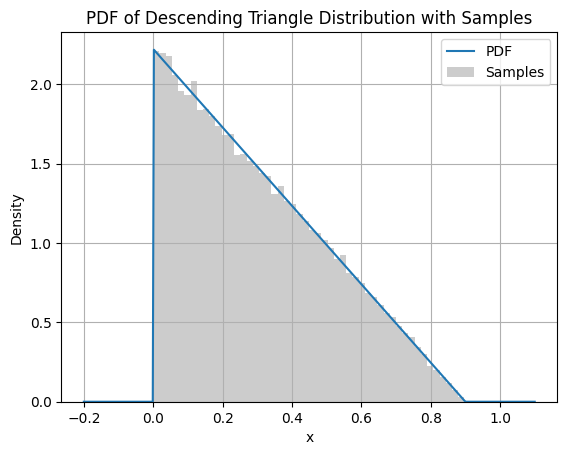

In [ ]:
import torch
import matplotlib.pyplot as plt


import torch
import matplotlib.pyplot as plt


class DescendingTriangle(torch.distributions.Distribution):
    arg_constraints = {'low': torch.distributions.constraints.real,
                       'high': torch.distributions.constraints.dependent}
    support = torch.distributions.constraints.dependent
    has_rsample = False

    def __init__(self, low, high, validate_args=None):
        self.low = torch.tensor(low)
        self.high = torch.tensor(high)
        if self.low >= self.high:
            raise ValueError("low must be less than high")
        self.scale = self.high - self.low
        self.C = 2.0 / self.scale**2
        super().__init__(validate_args=validate_args)

    def log_prob(self, value):
        value = torch.tensor(value)
        within_bounds = (value >= self.low) & (value <= self.high)
        prob = self.C * (self.high - value)
        return torch.where(within_bounds, torch.log(prob), torch.tensor(float('-inf')))

    def cdf(self, value):
        value = torch.tensor(value)
        x = torch.clamp(value, self.low, self.high)
        return 1 - ((self.high - x) ** 2) / self.scale**2

    def sample(self, sample_shape=torch.Size()):
        u = torch.rand(sample_shape)
        return self.high - (1 - u).sqrt() * self.scale


a, b = 0.0, 0.9
dist = DescendingTriangle(a, b)
x_vals = torch.linspace(a - 0.2, b + 0.2, 400)
pdf_vals = torch.exp(dist.log_prob(x_vals))
cdf_vals = dist.cdf(x_vals)

# Draw samples and plot histogram on the PDF plot
samples = dist.sample((100000,))
plt.figure()
plt.plot(x_vals, pdf_vals, label='PDF')
plt.hist(samples.numpy(), bins=50, density=True,
         alpha=0.4, color='gray', label='Samples')
plt.title('PDF of Descending Triangle Distribution with Samples')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)
plt.legend()

plt.show()

In [ ]:


from torch.distributions.utils import broadcast_all
from torch.distributions import constraints, Distribution
from numbers import Number
import math
import torch
from torch.distributions import Independent


class CustomJointIndependent(Distribution):
    """A joint distribution over independent variables with user-provided distributions."""

    def __init__(self, distributions, validate_args=False):
        if not all(isinstance(d, Distribution) for d in distributions):
            raise ValueError(
                "All elements must be torch.distributions.Distribution instances.")

        self.distributions = distributions
        self._support = constraints.stack(
            [d.support for d in distributions], dim=-1)

        super().__init__(
            batch_shape=torch.Size(),
            event_shape=torch.Size([len(distributions)]),
            validate_args=validate_args
        )

    @property
    def support(self):
        return self._support

    def sample(self, sample_shape=torch.Size()):
        return torch.stack([d.sample(sample_shape) for d in self.distributions], dim=-1)

    def rsample(self, sample_shape=torch.Size()):
        if not all(getattr(d, "has_rsample", False) for d in self.distributions):
            raise NotImplementedError(
                "At least one component does not support rsample().")
        return torch.stack([d.rsample(sample_shape) for d in self.distributions], dim=-1)

    def log_prob(self, value):
        if value.shape[-1] != len(self.distributions):
            raise ValueError(
                f"Expected last dim size {len(self.distributions)}, got {value.shape[-1]}")
        if self._validate_args and not self.support.check(value).all():
            raise ValueError("Value out of support.")
        return torch.stack(
            [d.log_prob(v)
             for d, v in zip(self.distributions, value.unbind(-1))],
            dim=-1
        ).sum(-1)

    @property
    def mean(self):
        return torch.stack([d.mean for d in self.distributions], dim=-1)

    @property
    def variance(self):
        return torch.stack([d.variance for d in self.distributions], dim=-1)

    def entropy(self):
        return sum(d.entropy() for d in self.distributions)

In [ ]:
import torch
from torch.distributions import Uniform
from torch.distributions.constraints import stack


class CustomJointIndependent(torch.distributions.Distribution):
    def __init__(self, distributions, validate_args=False):
        self.distributions = distributions
        self._support = stack([d.support for d in distributions], dim=-1)
        super().__init__(batch_shape=torch.Size(), event_shape=torch.Size(
            [len(distributions)]), validate_args=validate_args)

    @property
    def support(self):
        return self._support

    def sample(self, sample_shape=torch.Size()):
        return torch.stack([d.sample(sample_shape) for d in self.distributions], dim=-1)


# Define two simple uniform distributions
dist1 = Uniform(0.0, 1.0)
dist2 = Uniform(2.0, 3.0)

# Create the custom joint distribution
joint_dist = CustomJointIndependent([dist1, dist2])

# Generate a sample
samples = joint_dist.sample((5,))  # shape (5, 2)

# Check if samples are within the support
is_valid = joint_dist.support.check(samples+2)

print("Samples:\n", samples)
print("Support Check:\n", is_valid)

Samples:
 tensor([[0.3943, 2.6959],
        [0.0700, 2.3707],
        [0.2934, 2.1624],
        [0.5636, 2.8157],
        [0.9096, 2.3547]])
Support Check:
 tensor([[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]])
